# Walkthrough COVID-19 Dataset

The data can be found at https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases and uses the confirmed cases, recovered, and death rates. The program starts out by explaining how the dataset is pre-processed and then encapsulates it in a function.

In [1]:
# Use Pandas to manipulate data sets & clean up data
import pandas as pd
# Read the file into a dataframe called "df"
df = pd.read_csv ("/Users/carlos/Desktop/confirmed0518.csv")

## To get a slice of the data frame you can use list comprehension.

In [2]:
us = df[ df['Country/Region'].str.contains("US", na=False) ]

us = df\[ CONDITION \]

Creates a new data frame object called "us" and it will copy all rows in df if the CONDITION is TRUE

df\['Country/Region'\].str.contains("US", na=False)

Returns TRUE or FALSE if a row in the data frame has a Countries/Regions value that contains a word with "US."

### Returning a View vs Changing the Dataframe

In [3]:
# Remove the columns that we do not care about
us = us.drop( columns=['Province/State', 'Country/Region', 'Lat', 'Long'] )

Review the difference between Shallow Copy and Deep Copy. The function "us.drop()" will make a deep copy of "us" and the original data frame remains unchanged.

Pay attention to "us = us.drop()"

Notice that the left MUST be assigned to the right side in order to actually manipulate the original data frame.

In [4]:
# Use numPy to manipulate matrices and access functions from Linear Algebra 
import numpy as np
numCols = us.columns.values

# Reshape the Matrix
america = pd.melt(us, value_vars = numCols, var_name = 'Date', value_name = 'Cases')

# Check out the last 10 observations in the df
america.tail(10)

## Doesn't work - turns the data into a timestamp
#america['Date']= pd.to_datetime(america['Date'])   
# Check the format of 'Date' column 
#america.info() 

,Date,Cases
107,5/8/20,1283929
108,5/9/20,1309550
109,5/10/20,1329260
110,5/11/20,1347881
111,5/12/20,1369376
112,5/13/20,1390406
113,5/14/20,1417774
114,5/15/20,1442824
115,5/16/20,1467820
116,5/17/20,1486757


In [5]:
# Use shape, dim, and describe to get the size of your data frame
# Get the number of observations in the dataset
observations = america.shape[0]

# Get the number of predictors in the dataset
predictors = america.shape[1]

# Get the dates that are used in the data set
start = america['Date'][0]
end = america['Date'][ observations-1]

# Get the number of cases from day zero to today
dayZero = america['Cases'][0]
today = america['Cases'][ observations-1]

# Using print() to display information
print("The dataset contains", observations, "observations across", predictors, 'predictors.' )
print("There was", dayZero, "case on", start, 'and', today, "cases on", end, '.' )

The dataset contains 117 observations across 2 predictors.
There was 1 case on 1/22/20 and 1486757 cases on 5/17/20 .


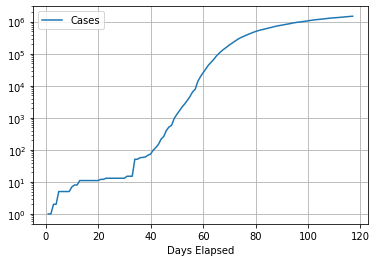

In [6]:
# In order to plot the data we need to have a numerical predictor
# The Date column is a string variable
# NaN's are incompatible with Pandas.plot()

# Make a list of the days that have passed from start to today
listCount = [x for x in range(1, observations+1)]
# Add the list as a column in our dataframe
america['Days Elapsed'] = listCount

# Now that we have a numerical predictor we can plot the dataset
# Plot the number of cases with respect to the number of days that have elapsed
# logy applies a log scale to 'Cases'
usPlot = america.plot.line(x='Days Elapsed', y='Cases', logy = True, grid = True)

[None]

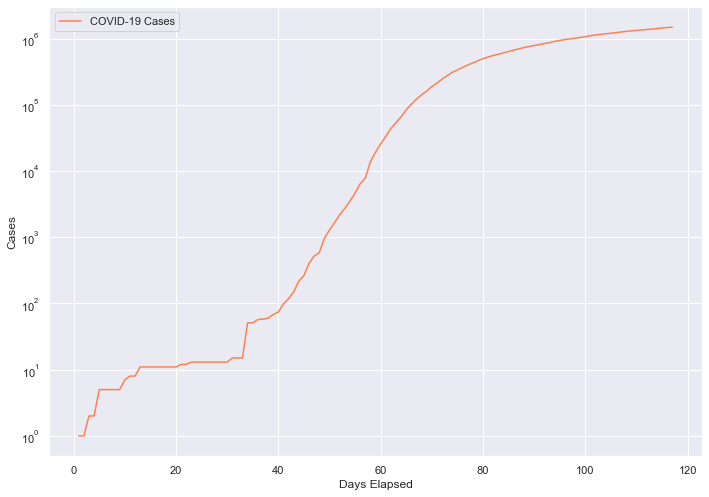

In [7]:
# Use seaborn to make visualizations
import seaborn as sns
sns.set(color_codes=True)

# Use pyplot to help customize renderings
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)

ax = sns.lineplot(x='Days Elapsed', y='Cases', data=america, color="coral", label="COVID-19 Cases")
ax.set(yscale="log")

The plot has some jagged corners that are caused by sudden increases in the number of cases. It would be convenient to have a graph that isn't so chaotic. Notice, that the graph would be conisdered "convenient" but not "better." Switching from a daily value to a smoothed value is a personal decision to help tone down sudden changes in the data. Rather than looking at a one day result you can use a multi-day average instead to apply locally optimized smoothing.

In [8]:
# Get a list of a 7 day rolling average
movingAvg = america['Cases'].rolling(7).mean()

# The first 6 rows are NaN bc they need to be manually calculated
# [:10] means show me all the values from the begining to the 10th observation
movingAvg[:10]

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
5         NaN
6    3.000000
7    3.571429
8    4.142857
9    4.857143
Name: Cases, dtype: float64

In [9]:
# Initialize the first value with the actual value
movingAvg[0] = america['Cases'][0]

# Get the Rolling Average of the first 6 observations
for i in range(1, 6):
    movingAvg[i] = america['Cases'][:i].mean()

# Show the current state of the data frame
movingAvg[:10]

0    1.000000
1    1.000000
2    1.000000
3    1.333333
4    1.500000
5    2.200000
6    3.000000
7    3.571429
8    4.142857
9    4.857143
Name: Cases, dtype: float64

#### Python is Strongly Typed == indentation is very important
america\['Cases'\]  = Get the data from the america data set and look at the column  called 'Cases'

\[:i\]  grab the first i observations

.mean() take the average of those observations

put that numerical value at the ith position in the list 'movingAvg'

[None]

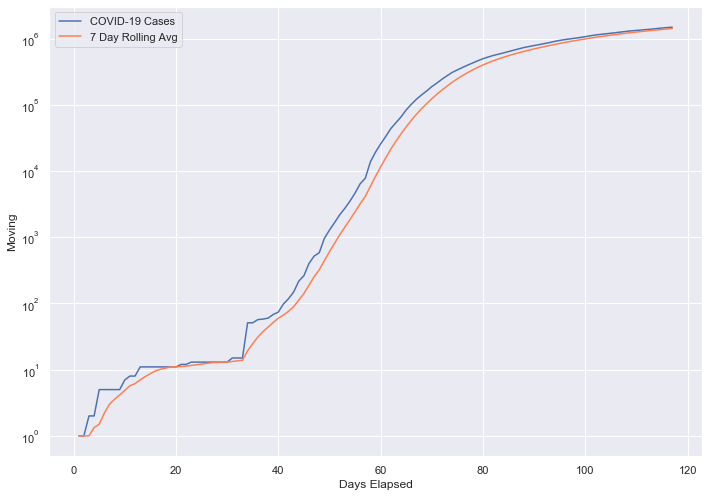

In [10]:
america['Moving'] = movingAvg

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.lineplot(x='Days Elapsed', y='Cases', data=america, color="b", label="COVID-19 Cases")
ax = sns.lineplot(x='Days Elapsed', y='Moving', data=america, color="coral", label="7 Day Rolling Avg")
ax.set(yscale="log")

This doesn't look right - the smoothed line is always underneath the actual result. The moving average is taking the average of the 7 days before today and that is causing the curve to be fitted below the actual growth. We need to move the average to be set in the middle of the window.

In [11]:
# Get a list of a 7 day rolling average
# Get the average of all cases that happened from 3 days ago to 3 days from today.
movAvg = america['Cases'].rolling(7, center = True).mean()

# Get the Rolling Average of the first and last 3 observations
for i in range(0, 3):
    # Take the mean of the first i observations
    movAvg[i] = america['Cases'][:i+4].mean()
    # Take the mean of the last i observations
    movAvg[observations - 1 - i] = america['Cases'][observations - i -4:].mean()

# Set the Moving Average to the new centered rolling average
america['Moving'] = movAvg

### Plotting multiple lines on the same graph
Generate a figure and axis object, customize your visualization as you see fit.
Use the axis object to plot the first line and then use the SAME axis to draw the second line.

[None]

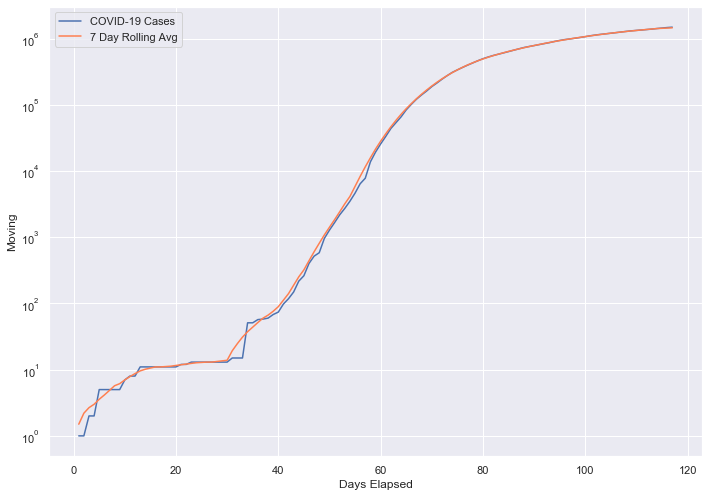

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

# First Line
ax = sns.lineplot(x='Days Elapsed', y='Cases', data=america, color="b", label="COVID-19 Cases")
# Second Line - You are not overwriting the previous plot but rather drawing a second line on the same plot.
ax = sns.lineplot(x='Days Elapsed', y='Moving', data=america, color="coral", label="7 Day Rolling Avg")
ax.set(yscale="log")

## Calculating the Growth Rate of the Virus

The Growth Rate, $\Delta C = \frac{\Delta C_{t}}{\Delta C_{y}}$, can be calculated by taking the amount of new cases that occured today ($\Delta C_{t}$) and divide it by the number of new cases that ocurred yesterday ($\Delta C_{y}$). A Growth Rate higher than 1 means that the virus is spreading while a growth rate that is less than 1 means that the virus is diminishing.

The basic reproduction number, $R_0$, is defined as the expected number of secondary cases
produced by a single (typical) infection in a completely susceptible population. It is important
to note that $R_0$ is a dimensionless number and NOT a rate, which would have units of time−1.

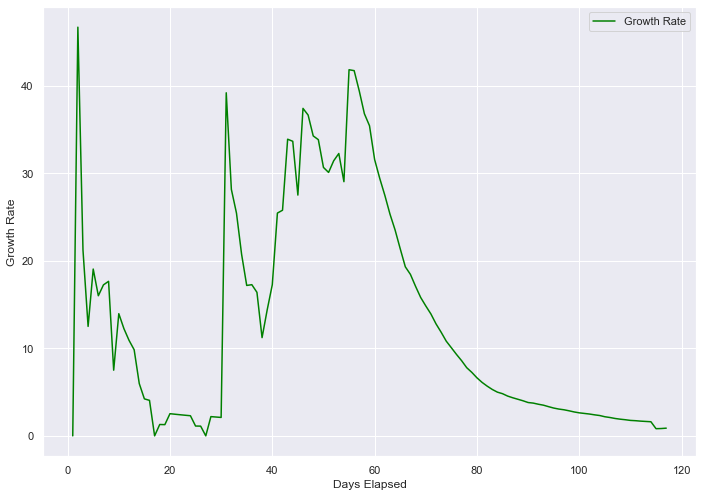

In [13]:
# Track the Derivative of the function to estimate the rate of change
growth = america['Moving'].pct_change().mul(100).round(3)
america['Growth Rate'] = growth
america.loc[ america.index[0],'Growth Rate' ] = 0 

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.lineplot(x='Days Elapsed', y='Growth Rate', data=america, color="green", label="Growth Rate")

When the growth rate is high then the number of cases is increasing. But the opposite is NOT true. A low growth rate does NOT mean that the cases will lower. Rather that the number of cases will start to stagnate. You can see that a low growth rate will result in a platueau or "flattened curve" in the plot.

The plot shows that there were a significant outbreaks on days 7, 33, 45, 50, and 56.

## Plot multiple lines on the same graph with different scales and customizations

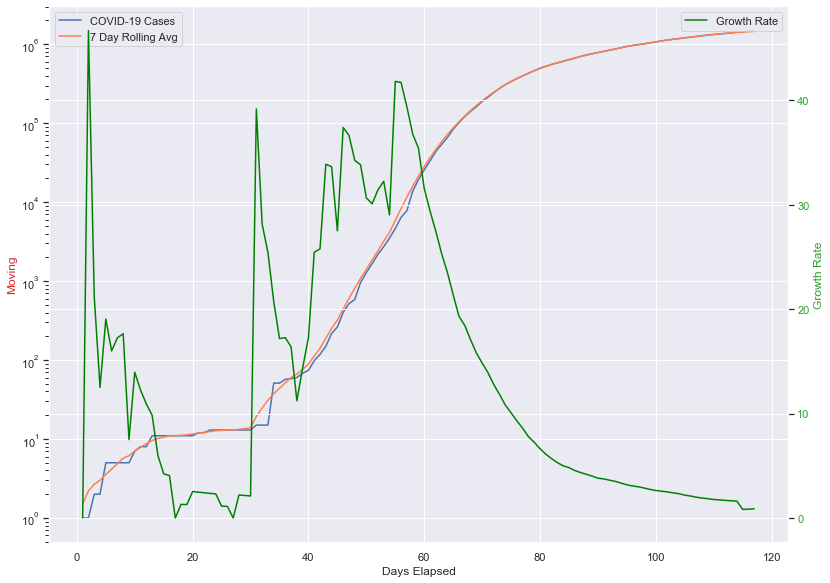

In [14]:
# create a figure and axis object
fig, ax1 = plt.subplots()
fig.set_size_inches(11.7, 8.27)

# Customize the first plot
color = 'tab:red'
ax1.set_xlabel('Time Elapsed (d)')
ax1.set_ylabel('Number of Cases', color=color)

# Draw two lines on the plot like you did before.
ax1 = sns.lineplot(x='Days Elapsed', y='Cases', data=america, color="b", label="COVID-19 Cases")
ax1 = sns.lineplot(x='Days Elapsed', y='Moving', data=america, color="coral", label="7 Day Rolling Avg")
ax1.set(yscale="log")

# Instantiate a second axis that shares the same x-axis as the first plot
ax2 = ax1.twinx()  

# Customize and plot as normal
color = 'tab:green'
ax2.set_ylabel('Growth Rate', color=color)  # we already handled the x-label with ax1
ax2 = sns.lineplot(x='Days Elapsed', y='Growth Rate', data=america, color="green", label="Growth Rate")
ax2.tick_params(axis='y', labelcolor=color)

# Set the borders; otherwise the right y-label is slightly clipped
fig.tight_layout()  

# Display the visualization
plt.show()

You can see that the green line drops significantly as the cases show very little growth.

In [15]:
print("The final data frame object has", america.shape[0], "observations,", america.shape[1]-1, "variables, and one predictor (the number of cases).")
america[observations-10 :]

The final data frame object has 117 observations, 4 variables, and one predictor (the number of cases).


,Date,Cases,Days Elapsed,Moving,Growth Rate
107,5/8/20,1283929,108,1.280189e+06,1.905
108,5/9/20,1309550,109,1.303764e+06,1.842
109,5/10/20,1329260,110,1.326775e+06,1.765
110,5/11/20,1347881,111,1.349739e+06,1.731
111,5/12/20,1369376,112,1.372439e+06,1.682
112,5/13/20,1390406,113,1.395049e+06,1.647
113,5/14/20,1417774,114,1.417548e+06,1.613
114,5/15/20,1442824,115,1.429160e+06,0.819
115,5/16/20,1467820,116,1.441116e+06,0.837
116,5/17/20,1486757,117,1.453794e+06,0.880


## Creating a closed hypothetical model in numPy

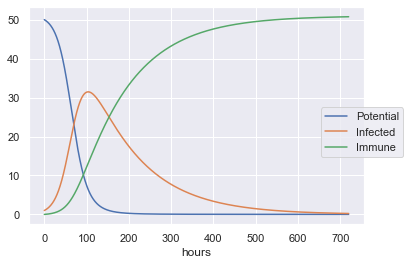

In [16]:
from numpy import zeros, linspace
import seaborn as sns 
import matplotlib.pyplot as plt

# Given Conditions
# What happens to virulence within a closed system?
# 10 people were infected in 24 hours - there were initially 40 people and 8 infected   
virulence = 10./(40*8*24)
# of the 15 infected, 3 recovered in 24 hours
cureRate = 3./(15*24)

# Simulation Duration
delta = 0.1
timePeriod = 30
simulationEnd = int(timePeriod*24/delta)

# Declare the size of the array and simulation space
time = linspace(0, simulationEnd*delta, simulationEnd+1)
Potential = zeros( simulationEnd+1)
Infected = zeros( simulationEnd+1)
Recovered = zeros( simulationEnd+1)

# Setup the initial conditions
Potential[0] = 50
Infected[0] = 1
Recovered[0] = 0

for today in range( simulationEnd ):
    tomorrow = today+1
    newInfections = delta * virulence * Potential[today]*Infected[today]
    newRecoveries = delta * cureRate * Infected[today]
    
    Potential[tomorrow] = Potential[today] - newInfections
    Infected[tomorrow] = Infected[today] + newInfections - newRecoveries
    Recovered[tomorrow] = Recovered[today] + newRecoveries

fig = plt.figure()
l1, l2, l3 = plt.plot(time, Potential, time, Infected, time, Recovered)
fig.legend( (l1, l2, l3), ('Potential', 'Infected', 'Immune'), 'right' )
plt.xlabel('hours')
plt.show()
#plt.savefig('tmp.pdf')

### Wrap Everything in a function so that we can reproduce the results on different countries.

In [82]:
# Precondition:  Given a dataframe df, a Country/Region as name, and window size n
# Postcondition: Returns a dataframe object that is preprocessed and cleaned 
def extract (df, name, n = 3, data = 'Cases'):   
    
    # Get a dataframe with only countries that match the name given
    country = df[ df['Country/Region'].str.contains(name, na=False) ]
    
    # If the country is not in the data set then exit from the function
    if country.shape[0] == 0:
        print('The country', name, 'does not exist in the dataset.')
        return country
    
    # The window is set to 3 if an invalid argument (or no argument) is given
    if n < 1:
        n = 3;
    
    # The fourth argument will tell us what type of data to use (Cases/ Recovered/ Deaths)
    if data != 'Cases' and data != 'Recovered' and data != 'Deaths' :
        print('Argument Given,', data, 'does not match the accepted data types. Please use the enumerated data types: Cases, Recovered, or Deaths')
        return country
    
    # Reshape the df
    country = country.drop( columns=['Province/State', 'Country/Region', 'Lat', 'Long'] )
    numCols = country.columns.values
    ct = pd.melt(country, value_vars = numCols, var_name = 'Date', value_name = data)
    count = ct.shape[0]
    
    if count < n :
        print('The dataframe has', count, 'observations and can not perform a rolling window of size', n ,'.')
        return country
    
    # Days Elapsed
    listCount = [x for x in range(1, count+1)]
    ct['Days Elapsed'] = listCount

    # Rolling Average
    mov = 'Moving '+ data
    movAvg = ct[data].rolling(1+(2*n), center = True).mean()
    for i in range(0, n):
        movAvg[i] = ct[data][:i+n+1].mean()
        movAvg[count - 1 - i] = ct[data][count - i -n -1:].mean()

    ct[mov] = movAvg
    
    # Locally Optimized Estimated Smoothing
    # Take the Rolling Average and anchor it to the actual result
    # This can be tweaked to get a different LOESS model
    loe = 'Loess ' + data
    loess = (ct[data]+movAvg)/2
    ct[loe] = loess
    
    # Growth Rate - Today's Cases / Yesterday's cases
    gro = 'Growth Rate ' + data
    growth = ct[mov].pct_change().mul(100).round(3)
    ct[gro] = growth.fillna(0)
    ct.loc[ ct[data] == 0, gro] = 0
    
    # New Cases - Today's cases - Yesterday's cases
    offs = 'Offset ' + data
    delta = ct[data].diff(periods=1)
    delta[0] = 0
    delta[count-1] = delta[count-2]
    ct[offs] = delta
    
    # Smooth the new cases by a window of size N
    delt = 'Delta ' + data
    delta = delta.rolling(n).mean()
    delta = delta.fillna(0).round(0)
    ct[delt] = delta

    
    # Visualizations
    fig, ax1 = plt.subplots()
    fig.set_size_inches(11, 8)
    color = 'tab:red'
    ax1.set_xlabel('Time Elapsed (d)')
    ax1.set_ylabel('Number of '+data, color=color)
    caption = 'COVID-19 Cases in ' + name
    ax1.set_title(caption)

    caption = str(n) + " Day Rolling Avg"
    #ax1 = sns.lineplot(x='Days Elapsed', y=mov, data=ct, color=color, label=caption, legend = False)
    ax1 = sns.lineplot(x='Days Elapsed', y=loe, data=ct, color=color, label=loe)
    #ax1 = sns.lineplot(x='Days Elapsed', y=data, data=ct, color="coral", label="COVID-19 Cases")

    ax1.set(yscale="log")
    ax1.legend(loc='best')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  

    color = 'tab:green'
    ax2.set_ylabel('Growth Rate', color=color)
    ax2 = sns.lineplot(x='Days Elapsed', y=gro, data=ct, color="green", label=gro, legend=False)
    ax2.legend(loc='lower right')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  
    plt.show()
    
    return ct

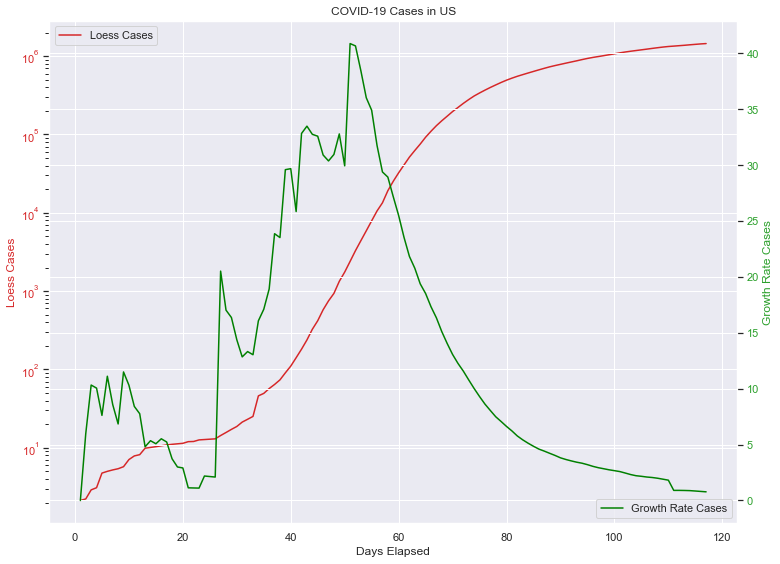

In [120]:
#sp = extract(df, "Spain")
#sk = extract(df, "Korea, South")
us = extract(df, "US", 7)

In [121]:
us.tail(15)

,Date,Cases,Days Elapsed,Moving Cases,Loess Cases,Growth Rate Cases,Offset Cases,Delta Cases
102,5/3/20,1158040,103,1.150917e+06,1.154479e+06,2.318,25501.0,27465.0
103,5/4/20,1180375,104,1.176390e+06,1.178383e+06,2.213,22335.0,27454.0
104,5/5/20,1204351,105,1.201802e+06,1.203077e+06,2.160,23976.0,27396.0
105,5/6/20,1229331,106,1.226990e+06,1.228161e+06,2.096,24980.0,27060.0
106,5/7/20,1257023,107,1.252181e+06,1.254602e+06,2.053,27692.0,26800.0
107,5/8/20,1283929,108,1.277075e+06,1.280502e+06,1.988,26906.0,25781.0
108,5/9/20,1309550,109,1.301365e+06,1.305458e+06,1.902,25621.0,25287.0
109,5/10/20,1329260,110,1.324980e+06,1.327120e+06,1.815,19710.0,24460.0
110,5/11/20,1347881,111,1.336904e+06,1.342393e+06,0.900,18621.0,23929.0
111,5/12/20,1369376,112,1.348945e+06,1.359160e+06,0.901,21495.0,23575.0


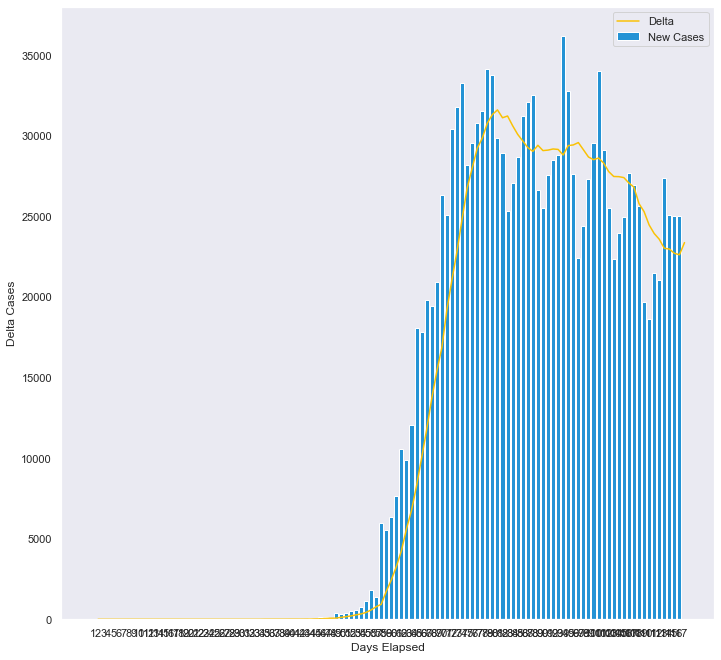

In [135]:
fig, ax = plt.subplots()
sns.set_style("dark")
fig.set_size_inches(11.7, 8.27)
ax = sns.barplot(x='Days Elapsed', y='Offset Cases', data=us, color= sns.xkcd_rgb["azure"], label="New Cases")
ax = sns.lineplot(x='Days Elapsed', y='Delta Cases', data=us, color =sns.xkcd_rgb["goldenrod"], label="Delta")

Let's do the same with the other datasets for the Recovered and Deaths

In [124]:
# Read the file into a dataframe called "rec"
rec = pd.read_csv ("/Users/carlos/Desktop/recovered0518.csv")
dea = pd.read_csv ("/Users/carlos/Desktop/deaths0518.csv")

Use the fourth argument to designate the type of data used:
As shown with the Recovered and Deaths datasets

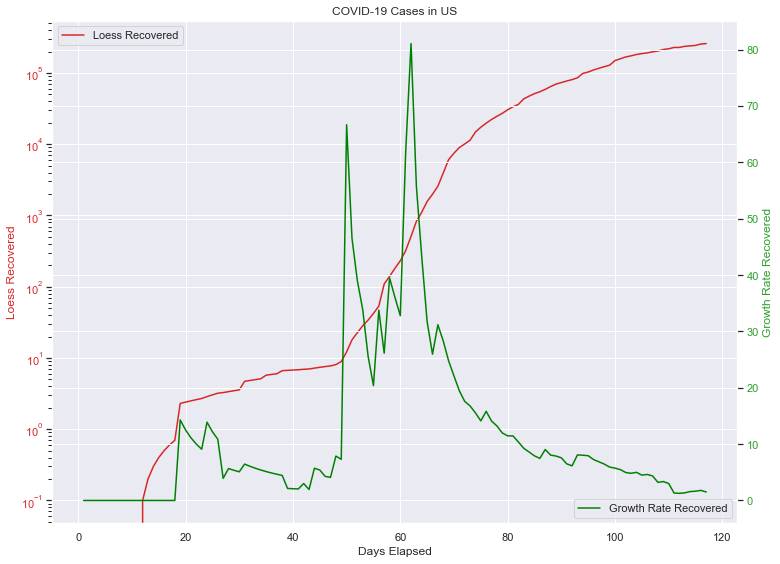

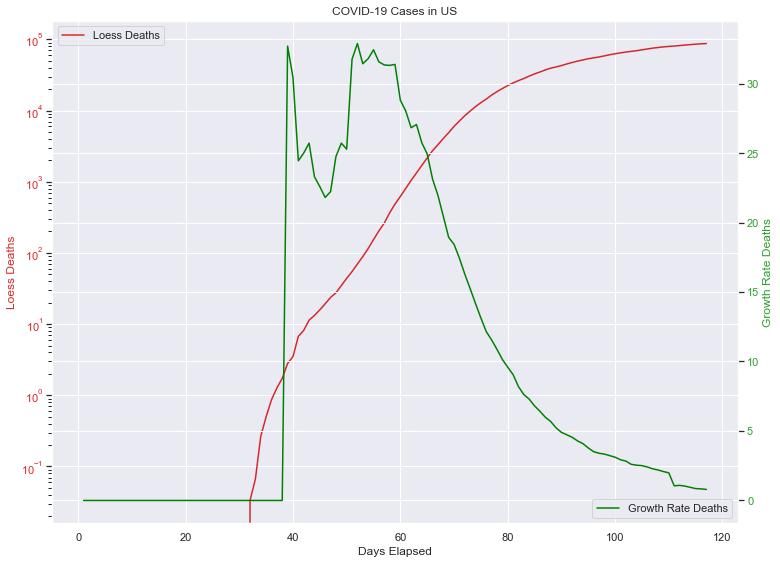

In [125]:
usRec = extract(rec, "US", 7, 'Recovered')
usDea = extract(dea, "US", 7, 'Deaths')

In [126]:
# Move columns in a df and outer joins

us = us.reindex(columns = ['Date', 'Days Elapsed', 'Cases','Moving Cases', 'Loess Cases',
       'Growth Rate Cases', 'Offset Cases', 'Delta Cases'])

us = pd.merge(us, usRec, how='outer', on=['Days Elapsed', 'Date'])
us = pd.merge(us, usDea, how='outer', on=['Days Elapsed', 'Date'])

us

,Date,Days Elapsed,Cases,Moving Cases,Loess Cases,Growth Rate Cases,Offset Cases,Delta Cases,Recovered,Moving Recovered,Loess Recovered,Growth Rate Recovered,Offset Recovered,Delta Recovered,Deaths,Moving Deaths,Loess Deaths,Growth Rate Deaths,Offset Deaths,Delta Deaths
0,1/22/20,1,1,3.250000e+00,2.125000e+00,0.000,0.0,0.0,0,0.000000,0.000000,0.000,0.0,0.0,0,0.000000,0.000000,0.000,0.0,0.0
1,1/23/20,2,1,3.444444e+00,2.222222e+00,5.983,0.0,0.0,0,0.000000,0.000000,0.000,0.0,0.0,0,0.000000,0.000000,0.000,0.0,0.0
2,1/24/20,3,2,3.800000e+00,2.900000e+00,10.323,1.0,0.0,0,0.000000,0.000000,0.000,0.0,0.0,0,0.000000,0.000000,0.000,0.0,0.0
3,1/25/20,4,2,4.181818e+00,3.090909e+00,10.048,0.0,0.0,0,0.000000,0.000000,0.000,0.0,0.0,0,0.000000,0.000000,0.000,0.0,0.0
4,1/26/20,5,5,4.500000e+00,4.750000e+00,7.609,3.0,0.0,0,0.000000,0.000000,0.000,0.0,0.0,0,0.000000,0.000000,0.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,5/13/20,113,1390406,1.360994e+06,1.375700e+06,0.893,21030.0,23011.0,243430,229741.166667,236585.583333,1.356,13143.0,7646.0,84119,81959.916667,83039.458333,1.033,1763.0,1523.0
113,5/14/20,114,1417774,1.372964e+06,1.395369e+06,0.879,27368.0,22964.0,246414,233362.181818,239888.090909,1.576,2984.0,7340.0,85898,82733.090909,84315.545455,0.943,1779.0,1462.0
114,5/15/20,115,1442824,1.384558e+06,1.413691e+06,0.844,25050.0,22699.0,250747,237194.800000,243970.900000,1.642,4333.0,7393.0,87530,83440.200000,85485.100000,0.855,1632.0,1479.0
115,5/16/20,116,1467820,1.395739e+06,1.431779e+06,0.808,24996.0,22610.0,268376,241439.444444,254907.722222,1.790,17629.0,7977.0,88754,84135.777778,86444.888889,0.834,1224.0,1423.0


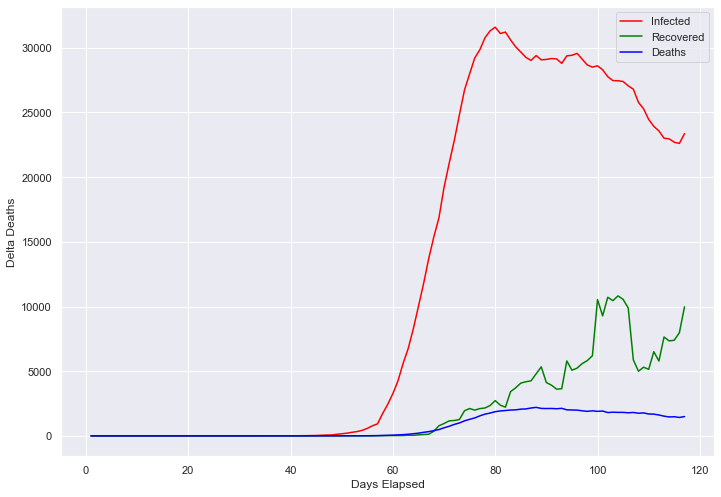

In [127]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.lineplot(x='Days Elapsed', y='Delta Cases', data=us, color="red", label="Infected")
ax = sns.lineplot(x='Days Elapsed', y='Delta Recovered', data=us, color="green", label="Recovered")
ax = sns.lineplot(x='Days Elapsed', y='Delta Deaths', data=us, color="blue", label="Deaths")

Combine everything into one dataset for Confirmed Cases, Recovered, and Deaths

In [22]:
def combineDF(alpha, beta, gamma, country, size = 3):
    caseCT = extract(alpha, country, size)
    recCT = extract(beta, country, size, 'Recovered')
    deaCT = extract(gamma, country, size, 'Deaths')

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,...,472,502,558,558,610,648,691,745,745,778
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,620,627,650,654,682,688,694,705,714,715
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,2467,2546,2678,2841,2998,3058,3158,3271,3409,3507
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,537,545,550,550,568,576,596,604,615,617
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,11,13,13,13,13,14,14,17,17,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,...,4,4,4,4,4,4,4,4,4,4
249,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
250,NaN,Comoros,-11.645500,43.333300,0,0,0,0,0,0,...,0,0,0,0,0,0,3,3,3,3
251,NaN,Tajikistan,38.861034,71.276093,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
